In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Models/

/content/drive/MyDrive/Models


# Importing the needed Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from scipy.stats import pearsonr
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import calendar
from matplotlib.ticker import FuncFormatter
import datetime
import joblib
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

# Loading and Processing Data

In [4]:
data = pd.read_csv('San Antonio.csv')
data.head()

,DATE,Water Flows,RAW WATER TURBIDITY (NTU),RO FEED TURBIDITY (NTU),RAW WATER TDS (MG/L),FINISHED WATER TURBIDITY (NTU),FINISHED WATER TDS (MG/L),Daily KWH,Daily COST
0,2017-01-01,4.98,NaN,0.04,NaN,0.28,129.2,15822.580645,1335.741935
1,2017-01-02,4.95,NaN,0.14,NaN,0.12,136.0,15822.580645,1335.741935
2,2017-01-03,3.68,NaN,0.71,NaN,0.17,131.2,15822.580645,1335.741935
3,2017-01-04,4.99,NaN,0.55,1300.0,0.16,131.5,15822.580645,1335.741935
4,2017-01-05,4.86,NaN,0.36,NaN,0.16,127.4,15822.580645,1335.741935


In [5]:
column_data_types = data.dtypes

# Print the data types
print("Data types of each column in the DataFrame:")
print(column_data_types)

Data types of each column in the DataFrame:
DATE                               object
Water Flows                       float64
RAW WATER TURBIDITY (NTU)         float64
RO FEED TURBIDITY (NTU)           float64
RAW WATER TDS (MG/L)              float64
FINISHED WATER TURBIDITY (NTU)    float64
FINISHED WATER TDS (MG/L)         float64
Daily KWH                         float64
Daily COST                        float64
dtype: object


In [6]:
# Convert the 'DATE' column to datetime format (if it's not already)
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract the 'Day', 'Month', and 'Year' from the 'DATE' column
data['Day'] = data['DATE'].dt.day
data['Month'] = data['DATE'].dt.month
data['Year'] = data['DATE'].dt.year

# Drop the original 'DATE' column (optional)
# data = data.drop('DATE', axis=1)

# Display the modified dataframe
print(data.head())


        DATE  Water Flows  RAW WATER TURBIDITY (NTU)  RO FEED TURBIDITY (NTU)  \
0 2017-01-01         4.98                        NaN                     0.04   
1 2017-01-02         4.95                        NaN                     0.14   
2 2017-01-03         3.68                        NaN                     0.71   
3 2017-01-04         4.99                        NaN                     0.55   
4 2017-01-05         4.86                        NaN                     0.36   

   RAW WATER TDS (MG/L)  FINISHED WATER TURBIDITY (NTU)  \
0                   NaN                            0.28   
1                   NaN                            0.12   
2                   NaN                            0.17   
3                1300.0                            0.16   
4                   NaN                            0.16   

   FINISHED WATER TDS (MG/L)     Daily KWH   Daily COST  Day  Month  Year  
0                      129.2  15822.580645  1335.741935    1      1  2017  
1     

In [7]:
# Convert DATE to datetime object and set as index
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Sort the index
data.sort_index(inplace=True)

# Apply forward-fill
data.fillna(method='ffill', inplace=True)

# Apply backward-fill for any remaining missing values
data.fillna(method='bfill', inplace=True)

# Apply polynomial interpolation
try:
    data.interpolate(method='polynomial', order=2, inplace=True)
except Exception as e:
    print(f"An error occurred: {e}")



In [8]:
data.head()

,Water Flows,RAW WATER TURBIDITY (NTU),RO FEED TURBIDITY (NTU),RAW WATER TDS (MG/L),FINISHED WATER TURBIDITY (NTU),FINISHED WATER TDS (MG/L),Daily KWH,Daily COST,Day,Month,Year
DATE,,,,,,,,,,,
2017-01-01,4.98,0.87,0.04,1300.0,0.28,129.2,15822.580645,1335.741935,1,1,2017
2017-01-02,4.95,0.87,0.14,1300.0,0.12,136.0,15822.580645,1335.741935,2,1,2017
2017-01-03,3.68,0.87,0.71,1300.0,0.17,131.2,15822.580645,1335.741935,3,1,2017
2017-01-04,4.99,0.87,0.55,1300.0,0.16,131.5,15822.580645,1335.741935,4,1,2017
2017-01-05,4.86,0.87,0.36,1300.0,0.16,127.4,15822.580645,1335.741935,5,1,2017


# Exploratory Data Analysis

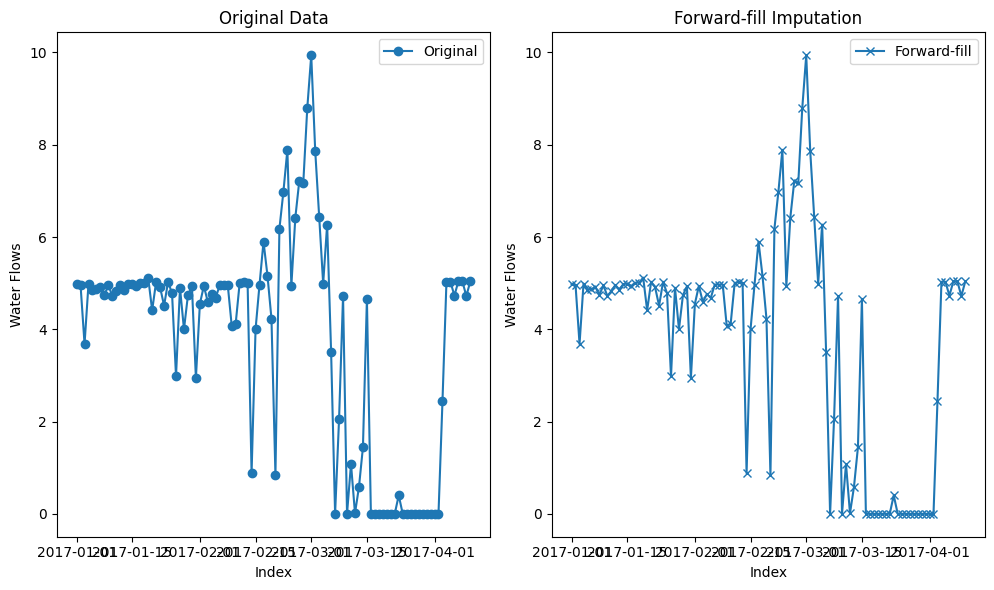

In [9]:
import matplotlib.pyplot as plt

# Apply forward-fill imputation
data_ffill = data.fillna(method='ffill')

# Select a subset of the data for better visualization (e.g., first 100 rows)
subset_length = 100

# Plot original data
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.plot(data['Water Flows'][:subset_length], label='Original', marker='o')
plt.title('Original Data')
plt.xlabel('Index')
plt.ylabel('Water Flows')
plt.legend()

# Plot data after forward-fill
plt.subplot(1, 3, 2)
plt.plot(data_ffill['Water Flows'][:subset_length], label='Forward-fill', marker='x')
plt.title('Forward-fill Imputation')
plt.xlabel('Index')
plt.ylabel('Water Flows')
plt.legend()

plt.tight_layout()
plt.show()


# Time Plot for Treated Water and Energy Consumption

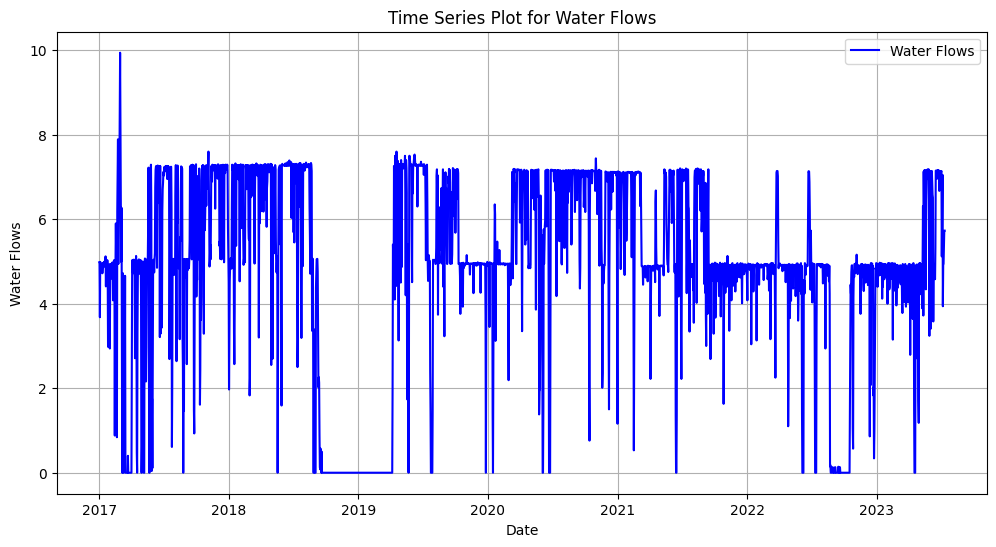

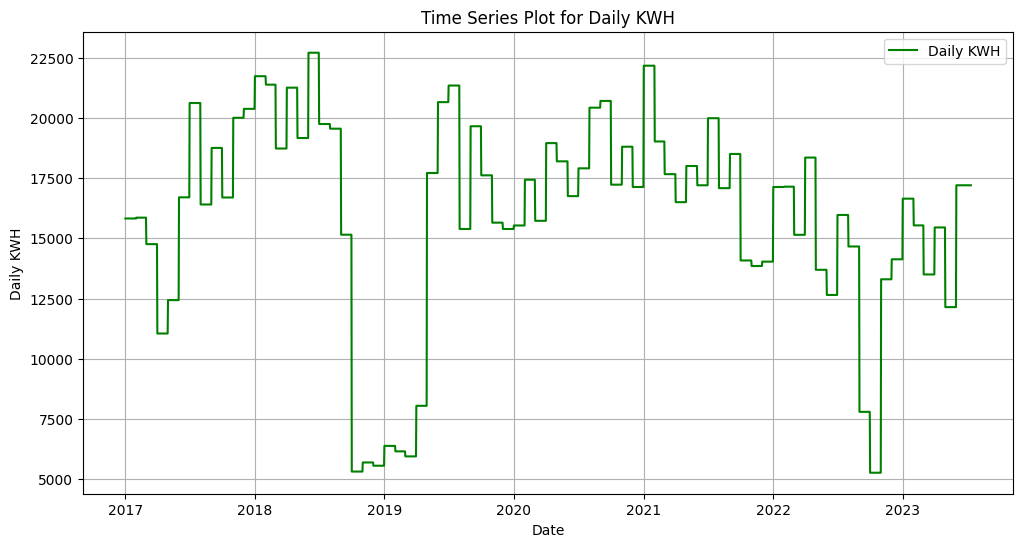

In [10]:
# Time series plot for 'Water Flows'
plt.figure(figsize=(12, 6))
plt.plot(data['Water Flows'], label='Water Flows', color='blue')
plt.title('Time Series Plot for Water Flows')
plt.xlabel('Date')
plt.ylabel('Water Flows')
plt.legend()
plt.grid(True)
plt.show()

# Time series plot for 'Daily KWH'
plt.figure(figsize=(12, 6))
plt.plot(data['Daily KWH'], label='Daily KWH', color='green')
plt.title('Time Series Plot for Daily KWH')
plt.xlabel('Date')
plt.ylabel('Daily KWH')
plt.legend()
plt.grid(True)
plt.show()


# Seasonal Decomposition for Treated Water and Energy Consumption

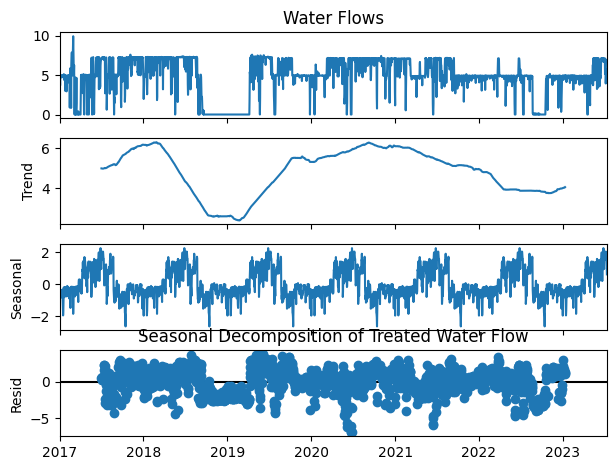

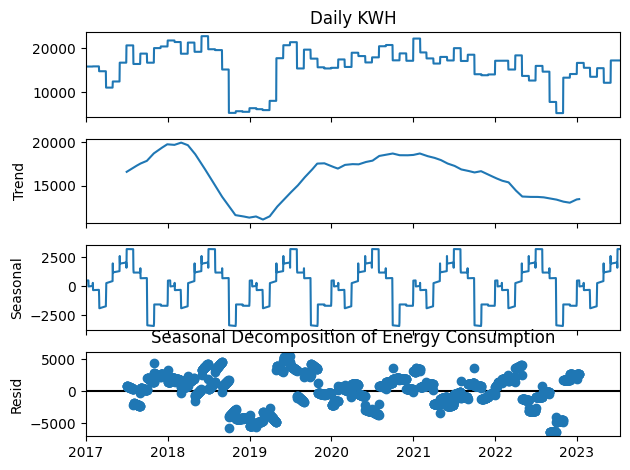

In [11]:
# Seasonal Decomposition for Treated Water
decomposition_treated = seasonal_decompose(data['Water Flows'], period=365)
decomposition_treated.plot()
plt.title('Seasonal Decomposition of Treated Water Flow')
plt.show()

# Seasonal Decomposition for Raw Water
decomposition_raw = seasonal_decompose(data['Daily KWH'], period=365)
decomposition_raw.plot()
plt.title('Seasonal Decomposition of Energy Consumption')
plt.show()


# Lag Creation for Treated Water and Energy Consumption

In [12]:
# Number of lags to create
n_lags = 3

# Create lagged features for "Water Flows"
for i in range(1, n_lags + 1):
    col_name = f'Water_Flows_Lag_{i}'
    data[col_name] = data['Water Flows'].shift(i)

# Create lagged features for "Daily KWH"
for i in range(1, n_lags + 1):
    col_name = f'Daily_KWH_Lag_{i}'
    data[col_name] = data['Daily KWH'].shift(i)

# Remove the rows with NaN values generated by shifting
data.dropna(inplace=True)

# Show the first few rows to confirm
print(data.head())

            Water Flows  RAW WATER TURBIDITY (NTU)  RO FEED TURBIDITY (NTU)  \
DATE                                                                          
2017-01-04         4.99                       0.87                     0.55   
2017-01-05         4.86                       0.87                     0.36   
2017-01-06         4.87                       0.87                     0.09   
2017-01-07         4.91                       0.87                     0.04   
2017-01-08         4.75                       0.87                     0.07   

            RAW WATER TDS (MG/L)  FINISHED WATER TURBIDITY (NTU)  \
DATE                                                               
2017-01-04                1300.0                            0.16   
2017-01-05                1300.0                            0.16   
2017-01-06                1300.0                            0.18   
2017-01-07                1300.0                            0.17   
2017-01-08                1300.0      

# ADF Test for Treated Water and Energy Consumption

In [13]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ')

# Apply the test on your time series data
adf_test(data['Water Flows'])
adf_test(data['Daily KWH'])


ADF Statistic: -4.4283870059064965
p-value: 0.00026431554259941873
Critical Values: {'1%': -3.4331156974460857, '5%': -2.862761840265617, '10%': -2.5674204379950414}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
ADF Statistic: -3.2301380393529655
p-value: 0.01830511990045553
Critical Values: {'1%': -3.433100574354779, '5%': -2.862755162210213, '10%': -2.5674168824588657}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# Data Preprocessing

In [14]:
# Resetting the index to move 'DATE' back to a column
data.reset_index(inplace=True)

In [15]:
data.head()

column_data_types = data.dtypes

# Print the data types
print("Data types of each column in the DataFrame:")
print(column_data_types)

Data types of each column in the DataFrame:
DATE                              datetime64[ns]
Water Flows                              float64
RAW WATER TURBIDITY (NTU)                float64
RO FEED TURBIDITY (NTU)                  float64
RAW WATER TDS (MG/L)                     float64
FINISHED WATER TURBIDITY (NTU)           float64
FINISHED WATER TDS (MG/L)                float64
Daily KWH                                float64
Daily COST                               float64
Day                                        int64
Month                                      int64
Year                                       int64
Water_Flows_Lag_1                        float64
Water_Flows_Lag_2                        float64
Water_Flows_Lag_3                        float64
Daily_KWH_Lag_1                          float64
Daily_KWH_Lag_2                          float64
Daily_KWH_Lag_3                          float64
dtype: object


# 50:50 Data Partitioning

In [16]:
# Split sizes
train_size = int(len(data) * 0.5)  # 50% for training

# Train-Test Split
train, test = data[:train_size], data[train_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['DATE', 'Water Flows', 'Daily KWH'], axis=1)
y_train_treated_actual = train['Water Flows']
y_train_energy_actual = train['Daily KWH']

# Test data
X_test_actual = test.drop(['DATE', 'Water Flows', 'Daily KWH'], axis=1)
y_test_treated_actual = test['Water Flows']
y_test_energy_actual = test['Daily KWH']

print("Training set size:", len(X_train_actual))
print("Test set size:", len(X_test_actual))

Training set size: 1190
Test set size: 1191


# Initial ML Model and SARIMA for Treated Water and Energy Consumption

In [17]:
# Define a function for training machine learning models
def train_ml_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Define a function for training SARIMA models
def train_sarima_model(y_train, order, seasonal_order):
    try:
        sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
        sarima_fit = sarima_model.fit(disp=False)
        return sarima_fit
    except Exception as e:
        print("Error fitting SARIMA model:", str(e))
        return None

# Machine Learning Model Training for Treated Water
rf_model_treated = train_ml_model(RandomForestRegressor(), X_train_actual, y_train_treated_actual)
gb_model_treated = train_ml_model(GradientBoostingRegressor(), X_train_actual, y_train_treated_actual)

# Machine Learning Model Training for Energy Consumption
rf_model_energy = train_ml_model(RandomForestRegressor(), X_train_actual, y_train_energy_actual)
gb_model_energy = train_ml_model(GradientBoostingRegressor(), X_train_actual, y_train_energy_actual)

# SARIMA Model Training for Treated Water
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 12)
sarima_fit_treated = train_sarima_model(y_train_treated_actual, sarima_order, sarima_seasonal_order)

# SARIMA Model Training for Energy Consumption
sarima_fit_energy = train_sarima_model(y_train_energy_actual, sarima_order, sarima_seasonal_order)


# Prediction from Initial ML and SARIMA Model for Treated Water on Test Dataset on 50:50 dataset

In [18]:
# Making Predictions for Actual Values on Test Set
rf_pred_treated_test = rf_model_treated.predict(X_test_actual)
gb_pred_treated_test = gb_model_treated.predict(X_test_actual)
rf_pred_energy_test = rf_model_energy.predict(X_test_actual)
gb_pred_energy_test = gb_model_energy.predict(X_test_actual)

# Making SARIMA Predictions for Actual Values on Test Set
sarima_pred_treated_test = sarima_fit_treated.predict(start=len(y_train_treated_actual), end=len(y_train_treated_actual) + len(y_test_treated_actual) - 1, dynamic=True)
sarima_pred_energy_test = sarima_fit_energy.predict(start=len(y_train_energy_actual), end=len(y_train_energy_actual) + len(y_test_energy_actual) - 1, dynamic=True)

# Convert SARIMA predictions to numpy arrays for consistency
sarima_pred_treated_test = np.array(sarima_pred_treated_test)
sarima_pred_energy_test = np.array(sarima_pred_energy_test)

# Ensemble Predictions for Actual Values on Test Set
treated_test_outputs = [rf_pred_treated_test, gb_pred_treated_test, sarima_pred_treated_test]
energy_test_outputs = [rf_pred_energy_test, gb_pred_energy_test, sarima_pred_energy_test]
ensemble_pred_treated_test = np.mean(treated_test_outputs, axis=0)
ensemble_pred_energy_test = np.mean(energy_test_outputs, axis=0)

# Model Assessment for Initial Models

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def error(y_true, y_pred, threshold=0.5):
    """
    Calculate the error rate based on a given threshold.
    The function returns the proportion of predictions that are off by more than the threshold.
    """
    return np.mean(np.abs(y_true - y_pred) > threshold)

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_treated_test, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_treated_test, "Gradient Boosting")
    evaluate_predictions(y_test_treated_actual, sarima_pred_treated_test, "SARIMA")
    evaluate_predictions(y_test_treated_actual, ensemble_pred_treated_test, "Ensemble")

    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_energy_actual, rf_pred_energy_test, "Random Forest")
    evaluate_predictions(y_test_energy_actual, gb_pred_energy_test, "Gradient Boosting")
    evaluate_predictions(y_test_energy_actual, sarima_pred_energy_test, "SARIMA")
    evaluate_predictions(y_test_energy_actual, ensemble_pred_energy_test, "Ensemble")

# Run the evaluations
main()


Evaluations for Water Flow:

=== Random Forest ===
RMSE: 1.0770
MAE: 0.7168
Error Rate: 0.4349

=== Gradient Boosting ===
RMSE: 1.0246
MAE: 0.6497
Error Rate: 0.4030

=== SARIMA ===
RMSE: 2.1491
MAE: 1.6571
Error Rate: 0.9370

=== Ensemble ===
RMSE: 1.3021
MAE: 0.9341
Error Rate: 0.6532

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 1843.6671
MAE: 1268.9322
Error Rate: 1.0000

=== Gradient Boosting ===
RMSE: 1761.9394
MAE: 1302.4524
Error Rate: 0.9992

=== SARIMA ===
RMSE: 8124.8823
MAE: 6688.8483
Error Rate: 1.0000

=== Ensemble ===
RMSE: 3221.6138
MAE: 2590.3707
Error Rate: 1.0000



# 60:20:20 Data Partitioning on Training, Testing and validation Data

In [20]:
# Split sizes
train_size = int(len(data) * 0.6)  # Adjusted to 60% for training
validation_size = int(len(data) * 0.2)  # Adjusted to 20% for validation

# Train-Validation-Test Split
train, temp = data[:train_size], data[train_size:]
validation, test = temp[:validation_size], temp[validation_size:]

# Prepare data for machine learning models for actual values
# Training data
X_train_actual = train.drop(['DATE', 'Water Flows', 'Daily KWH'], axis=1)
y_train_treated_actual = train['Water Flows']
y_train_energy_actual = train['Daily KWH']

# Validation data
X_validation_actual = validation.drop(['DATE', 'Water Flows', 'Daily KWH'], axis=1)
y_validation_treated_actual = validation['Water Flows']
y_validation_energy_actual = validation['Daily KWH']

# Test data
X_test_actual = test.drop(['DATE', 'Water Flows', 'Daily KWH'], axis=1)
y_test_treated_actual = test['Water Flows']
y_test_energy_actual = test['Daily KWH']

print("Training set size:", len(X_train_actual))
print("Validation set size:", len(X_validation_actual))
print("Test set size:", len(X_test_actual))


Training set size: 1428
Validation set size: 476
Test set size: 477


# ML Model and SARIMA on 60% Training Data

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define a function for training machine learning models
def train_ml_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Define a function for training SARIMA models
def train_sarima_model(y_train, order, seasonal_order):
    try:
        sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
        sarima_fit = sarima_model.fit(disp=False)
        return sarima_fit
    except Exception as e:
        print("Error fitting SARIMA model:", str(e))
        return None

# Machine Learning Model Training
rf_model_treated = train_ml_model(RandomForestRegressor(), X_train_actual, y_train_treated_actual)
gb_model_treated = train_ml_model(GradientBoostingRegressor(), X_train_actual, y_train_treated_actual)
rf_model_energy = train_ml_model(RandomForestRegressor(), X_train_actual, y_train_energy_actual)
gb_model_energy = train_ml_model(GradientBoostingRegressor(), X_train_actual, y_train_energy_actual)

# SARIMA Model Training
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 1, 12)
sarima_fit_treated = train_sarima_model(y_train_treated_actual, sarima_order, sarima_seasonal_order)
sarima_fit_energy = train_sarima_model(y_train_energy_actual, sarima_order, sarima_seasonal_order)


# Model Prediction on 20% Test

In [22]:
# Making Predictions for Actual Values on Validation Set
rf_pred_treated_validation = rf_model_treated.predict(X_validation_actual)
gb_pred_treated_validation = gb_model_treated.predict(X_validation_actual)
rf_pred_energy_validation = rf_model_energy.predict(X_validation_actual)
gb_pred_energy_validation = gb_model_energy.predict(X_validation_actual)

# Making SARIMA Predictions for Actual Values on Validation Set
sarima_pred_treated_validation = sarima_fit_treated.predict(start=len(y_train_treated_actual), end=len(y_train_treated_actual) + len(y_validation_treated_actual) - 1, dynamic=True)
sarima_pred_energy_validation = sarima_fit_energy.predict(start=len(y_train_energy_actual), end=len(y_train_energy_actual) + len(y_validation_energy_actual) - 1, dynamic=True)

# Convert SARIMA predictions to numpy arrays for consistency
sarima_pred_treated_validation = np.array(sarima_pred_treated_validation)
sarima_pred_energy_validation = np.array(sarima_pred_energy_validation)

# Ensemble Predictions for Actual Values on Validation Set
treated_validation_outputs = [rf_pred_treated_validation, gb_pred_treated_validation, sarima_pred_treated_validation]
energy_validation_outputs = [rf_pred_energy_validation, gb_pred_energy_validation, sarima_pred_energy_validation]
ensemble_pred_treated_validation = np.mean(treated_validation_outputs, axis=0)
ensemble_pred_energy_validation = np.mean(energy_validation_outputs, axis=0)


# Model Evaluation

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}\n")
    return rmse, mae

def main():
    # Evaluations for Water Flow
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_validation_treated_actual, rf_pred_treated_validation, "Random Forest")
    evaluate_predictions(y_validation_treated_actual, gb_pred_treated_validation, "Gradient Boosting")
    evaluate_predictions(y_validation_treated_actual, sarima_pred_treated_validation, "SARIMA")
    evaluate_predictions(y_validation_treated_actual, ensemble_pred_treated_validation, "Ensemble")

    # Evaluations for Energy Consumption
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_validation_energy_actual, rf_pred_energy_validation, "Random Forest")
    evaluate_predictions(y_validation_energy_actual, gb_pred_energy_validation, "Gradient Boosting")
    evaluate_predictions(y_validation_energy_actual, sarima_pred_energy_validation, "SARIMA")
    evaluate_predictions(y_validation_energy_actual, ensemble_pred_energy_validation, "Ensemble")

# Run the evaluations
main()


Evaluations for Water Flow:

=== Random Forest ===
RMSE: 0.8894
MAE: 0.5470

=== Gradient Boosting ===
RMSE: 0.8629
MAE: 0.5208

=== SARIMA ===
RMSE: 1.6192
MAE: 1.4064

=== Ensemble ===
RMSE: 1.0110
MAE: 0.7824

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 690.2481
MAE: 498.8417

=== Gradient Boosting ===
RMSE: 581.3566
MAE: 424.0274

=== SARIMA ===
RMSE: 2602.5309
MAE: 1975.4180

=== Ensemble ===
RMSE: 1219.8133
MAE: 918.1321



# Hyper Parameter Tunning on the Gradient Boost Model for Treated Water

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt

# Define the parameter grid for treated water
param_grid_treated = {
   'n_estimators': [50, 100, 200, 300, 500, 1000],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2', 'auto', 0.3, 0.5, 0.7]
}

# Initialize Gradient Boosting Regressor for treated water
gb_treated = GradientBoostingRegressor()

# Create the grid search object for treated water
grid_search_treated = GridSearchCV(estimator=gb_treated, param_grid=param_grid_treated,
                                   scoring='neg_mean_squared_error',
                                   cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the treated water data
grid_search_treated.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator for treated water
print("Best parameters found for treated water data: ", grid_search_treated.best_params_)
print("Best cross-validation score (RMSE) for treated water data: ", sqrt(-grid_search_treated.best_score_))

# Get the best estimator for treated water data
best_gb_treated = grid_search_treated.best_estimator_

Fitting 3 folds for each of 44100 candidates, totalling 132300 fits
Best parameters found for treated water data:  {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 50}
Best cross-validation score (RMSE) for treated water data:  1.2579302476160696


In [25]:
best_gb_treated = best_gb_treated.fit(X_train_actual, y_train_treated_actual)

# Validation curve for best tuned GB model on Treated Water Data

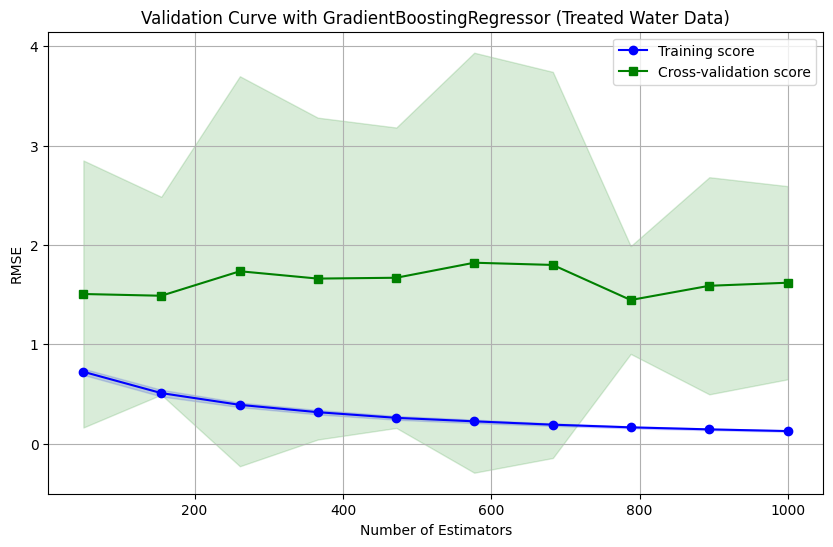

In [26]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the range of 'n_estimators' to explore
param_range = np.linspace(50, 1000, 10).astype(int)

# Use validation_curve to evaluate the model performance over the defined range of 'n_estimators'
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_treated.learning_rate,
                                        max_depth=best_gb_treated.max_depth,
                                        min_samples_split=best_gb_treated.min_samples_split,
                                        min_samples_leaf=best_gb_treated.min_samples_leaf,
                                        max_features=best_gb_treated.max_features),
    X=X_train_actual,
    y=y_train_treated_actual,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color="blue", alpha=0.15)
plt.plot(param_range, test_rmse, label="Cross-validation score", color="green", marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color="green", alpha=0.15)

plt.title("Validation Curve with GradientBoostingRegressor (Treated Water Data)")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Hyper Parameter Tunning on the Random Forest Model for Treated Water

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

# Define the parameter grid for the Random Forest model for treated water
param_grid_treated_rf = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

# Initialize Random Forest Regressor for treated water
rf_treated = RandomForestRegressor()

# Create the grid search object for treated water
grid_search_treated_rf = GridSearchCV(estimator=rf_treated, param_grid=param_grid_treated_rf,
                                      scoring='neg_mean_squared_error',
                                      cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the treated water data
grid_search_treated_rf.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator for treated water
print("Best parameters found for treated water data using Random Forest: ", grid_search_treated_rf.best_params_)
rmse_score_rf = sqrt(-grid_search_treated_rf.best_score_)
print("Best cross-validation score (RMSE) for treated water data using Random Forest: ", rmse_score_rf)

# Get the best estimator for treated water data
best_rf_treated = grid_search_treated_rf.best_estimator_


Fitting 3 folds for each of 14400 candidates, totalling 43200 fits
Best parameters found for treated water data using Random Forest:  {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best cross-validation score (RMSE) for treated water data using Random Forest:  1.2516339303362392


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [28]:
best_rf_treated = best_rf_treated.fit(X_train_actual, y_train_treated_actual)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


# Validation curve for best tuned RF model on Treated Water Data

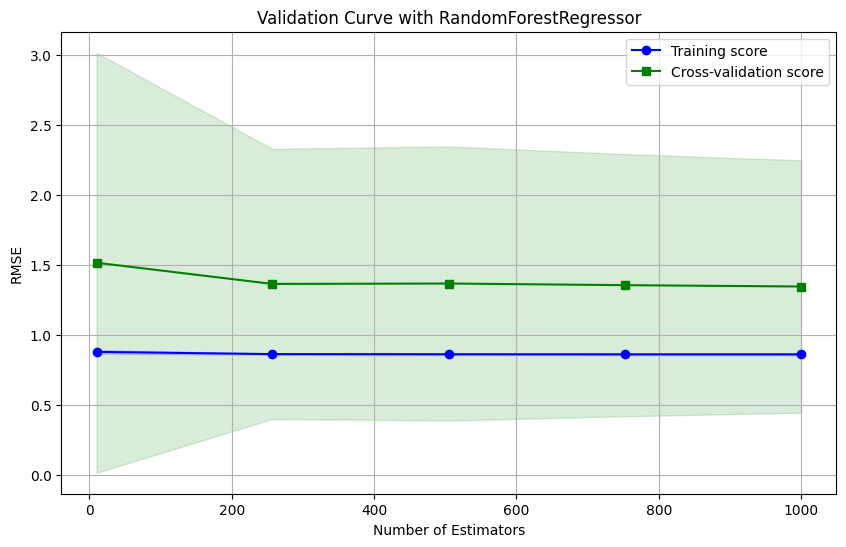

In [29]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_actual and y_train_treated_actual are your training data

# Define the range of 'n_estimators' to explore
param_range = np.linspace(10, 1000, 5).astype(int)

# Extract the best parameters but exclude 'n_estimators' to vary it in the validation curve
fixed_params = {k: v for k, v in grid_search_treated_rf.best_params_.items() if k != 'n_estimators'}

# Initialize a new RandomForestRegressor with the best parameters found, excluding 'n_estimators'
rf_model = RandomForestRegressor(**fixed_params, random_state=42)  # Ensure reproducibility

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=rf_model,
    X=X_train_actual,
    y=y_train_treated_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label='Training score', color='blue', marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color='blue', alpha=0.15)
plt.plot(param_range, test_rmse, label='Cross-validation score', color='green', marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color='green', alpha=0.15)

plt.title('Validation Curve with RandomForestRegressor')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Hyper Parameter Tunning on the Gradient Boost Model for Energy Consumption

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt

# Define the parameter grid for energy
param_grid_energy = {
   'n_estimators': [50, 100, 200, 300, 500, 1000],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2', 'auto', 0.3, 0.5, 0.7]
}

# Initialize Gradient Boosting Regressor for energy
gb_energy = GradientBoostingRegressor()

# Create the grid search object for energy
grid_search_energy = GridSearchCV(estimator=gb_energy, param_grid=param_grid_energy,
                                  scoring='neg_mean_squared_error',
                                  cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy data
grid_search_energy.fit(X_train_actual, y_train_energy_actual)

# Print the best parameters and estimator for energy
print("Best parameters found for energy data: ", grid_search_energy.best_params_)
print("Best cross-validation score (RMSE) for energy data: ", sqrt(-grid_search_energy.best_score_))

# Get the best estimator for energy data
best_gb_energy = grid_search_energy.best_estimator_

Fitting 3 folds for each of 44100 candidates, totalling 132300 fits
Best parameters found for energy data:  {'learning_rate': 0.5, 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}
Best cross-validation score (RMSE) for energy data:  1558.4125302218065


In [31]:
best_gb_energy = best_gb_energy.fit(X_train_actual, y_train_energy_actual)

# Validation curve for best tuned GB model on Energy Consumption Data

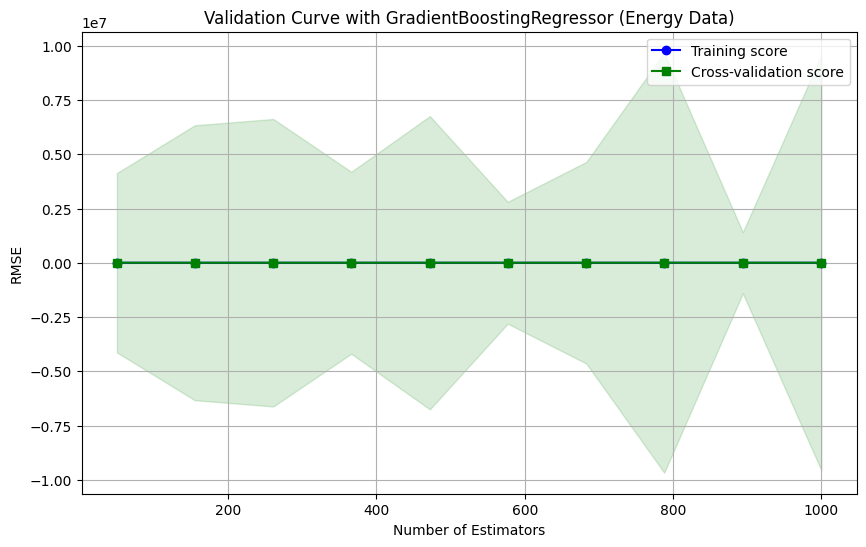

In [32]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the range of 'n_estimators' to explore
param_range = np.linspace(50, 1000, 10).astype(int)

# Use validation_curve to evaluate the model performance over the defined range of 'n_estimators'
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_energy.learning_rate,
                                        max_depth=best_gb_energy.max_depth,
                                        min_samples_split=best_gb_energy.min_samples_split,
                                        min_samples_leaf=best_gb_energy.min_samples_leaf,
                                        max_features=best_gb_energy.max_features),
    X=X_train_actual,
    y=y_train_energy_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label='Training score', color='blue', marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color='blue', alpha=0.15)
plt.plot(param_range, test_rmse, label='Cross-validation score', color='green', marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color='green', alpha=0.15)

plt.title('Validation Curve with GradientBoostingRegressor (Energy Data)')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Hyper Parameter Tunning on the Random Forest Model for Energy Consumption

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

# Define the parameter grid for the Random Forest model for energy
param_grid_energy_rf = {
    'n_estimators': [50, 100, 200, 300, 500, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

# Initialize Random Forest Regressor for energy
rf_energy = RandomForestRegressor()

# Create the grid search object for energy
grid_search_energy_rf = GridSearchCV(estimator=rf_energy, param_grid=param_grid_energy_rf,
                                     scoring='neg_mean_squared_error',
                                     cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy data
grid_search_energy_rf.fit(X_train_actual, y_train_energy_actual)

# Print the best parameters and estimator for energy
print("Best parameters found for energy data using Random Forest: ", grid_search_energy_rf.best_params_)
rmse_score_rf = sqrt(-grid_search_energy_rf.best_score_)
print("Best cross-validation score (RMSE) for energy data using Random Forest: ", rmse_score_rf)

# Get the best estimator for energy data
best_rf_energy = grid_search_energy_rf.best_estimator_


Fitting 3 folds for each of 14400 candidates, totalling 43200 fits
Best parameters found for energy data using Random Forest:  {'bootstrap': True, 'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 50}
Best cross-validation score (RMSE) for energy data using Random Forest:  2250.8844318327765


In [34]:
best_rf_energy = best_rf_energy.fit(X_train_actual, y_train_energy_actual)

# Validation curve for best tuned RF model on Energy Consumption Data

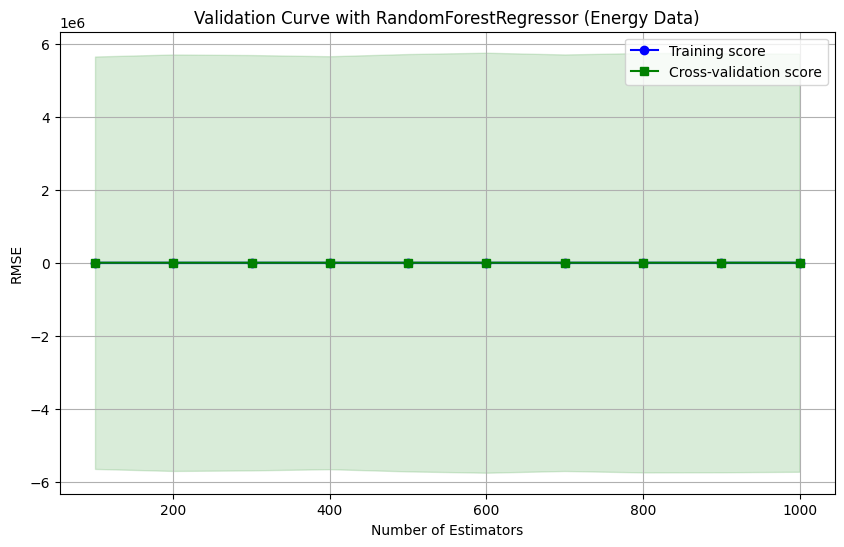

In [35]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the range of 'n_estimators' to explore
param_range = np.linspace(100, 1000, 10).astype(int)  # Adjust based on your computational capacity

# Use validation_curve to evaluate the model performance over the defined range of 'n_estimators'
train_scores, test_scores = validation_curve(
    estimator=RandomForestRegressor(max_depth=best_rf_energy.max_depth,
                                    min_samples_split=best_rf_energy.min_samples_split,
                                    min_samples_leaf=best_rf_energy.min_samples_leaf,
                                    max_features=best_rf_energy.max_features,
                                    bootstrap=best_rf_energy.bootstrap,
                                    random_state=42),  # Ensure reproducibility
    X=X_train_actual,
    y=y_train_energy_actual,
    param_name='n_estimators',
    param_range=param_range,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_mean)
test_rmse = np.sqrt(-test_mean)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_rmse, label='Training score', color='blue', marker='o')
plt.fill_between(param_range, train_rmse - train_std, train_rmse + train_std, color='blue', alpha=0.15)
plt.plot(param_range, test_rmse, label='Cross-validation score', color='green', marker='s')
plt.fill_between(param_range, test_rmse - test_std, test_rmse + test_std, color='green', alpha=0.15)

plt.title('Validation Curve with RandomForestRegressor (Energy Data)')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Evaluation of Tuned GB and RF Model for Treated Water

In [36]:
# --- GB Model Predictions and Evaluations ---
y_pred_train_treated_gb = best_gb_treated.predict(X_train_actual)
rmse_train_treated_gb = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_gb))
mae_train_treated_gb = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_gb)
error_train_treated_gb = error(y_train_treated_actual, y_pred_train_treated_gb)

y_pred_test_treated_gb = best_gb_treated.predict(X_test_actual)
rmse_test_treated_gb = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_gb))
mae_test_treated_gb = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_gb)
error_test_treated_gb = error(y_test_treated_actual, y_pred_test_treated_gb)

print("=== GB Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_gb:.4f}")
print(f"MAE: {mae_train_treated_gb:.4f}")
print(f"Error Rate: {error_train_treated_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_gb:.4f}")
print(f"MAE: {mae_test_treated_gb:.4f}")
print(f"Error Rate: {error_test_treated_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_treated_rf = best_rf_treated.predict(X_train_actual)
rmse_train_treated_rf = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_rf))
mae_train_treated_rf = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_rf)
error_train_treated_rf = error(y_train_treated_actual, y_pred_train_treated_rf)

y_pred_test_treated_rf = best_rf_treated.predict(X_test_actual)
rmse_test_treated_rf = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_rf))
mae_test_treated_rf = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_rf)
error_test_treated_rf = error(y_test_treated_actual, y_pred_test_treated_rf)

print("=== RF Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_rf:.4f}")
print(f"MAE: {mae_train_treated_rf:.4f}")
print(f"Error Rate: {error_train_treated_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_rf:.4f}")
print(f"MAE: {mae_test_treated_rf:.4f}")
print(f"Error Rate: {error_test_treated_rf:.4f}\n")




=== GB Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.7817
MAE: 0.4859
Error Rate: 0.3214

--- Test Set ---
RMSE: 1.4455
MAE: 0.9298
Error Rate: 0.4340

=== RF Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.8999
MAE: 0.5420
Error Rate: 0.2969

--- Test Set ---
RMSE: 1.0804
MAE: 0.6833
Error Rate: 0.3774



# Evaluation of Tuned GB and RF Model for Energy Consumption

In [37]:

# --- GB Model Predictions and Evaluations ---
y_pred_train_energy_gb = best_gb_energy.predict(X_train_actual)
rmse_train_energy_gb = sqrt(mean_squared_error(y_train_energy_actual, y_pred_train_energy_gb))
mae_train_energy_gb = mean_absolute_error(y_train_energy_actual, y_pred_train_energy_gb)
error_train_energy_gb = error(y_train_energy_actual, y_pred_train_energy_gb)

y_pred_test_energy_gb = best_gb_energy.predict(X_test_actual)
rmse_test_energy_gb = sqrt(mean_squared_error(y_test_energy_actual, y_pred_test_energy_gb))
mae_test_energy_gb = mean_absolute_error(y_test_energy_actual, y_pred_test_energy_gb)
error_test_energy_gb = error(y_test_energy_actual, y_pred_test_energy_gb)

print("=== GB Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_gb:.4f}")
print(f"MAE: {mae_train_energy_gb:.4f}")
print(f"Error Rate: {error_train_energy_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_gb:.4f}")
print(f"MAE: {mae_test_energy_gb:.4f}")
print(f"Error Rate: {error_test_energy_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_energy_rf = best_rf_energy.predict(X_train_actual)
rmse_train_energy_rf = sqrt(mean_squared_error(y_train_energy_actual, y_pred_train_energy_rf))
mae_train_energy_rf = mean_absolute_error(y_train_energy_actual, y_pred_train_energy_rf)
error_train_energy_rf = error(y_train_energy_actual, y_pred_train_energy_rf)

y_pred_test_energy_rf = best_rf_energy.predict(X_test_actual)
rmse_test_energy_rf = sqrt(mean_squared_error(y_test_energy_actual, y_pred_test_energy_rf))
mae_test_energy_rf = mean_absolute_error(y_test_energy_actual, y_pred_test_energy_rf)
error_test_energy_rf = error(y_test_energy_actual, y_pred_test_energy_rf)

print("=== RF Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_rf:.4f}")
print(f"MAE: {mae_train_energy_rf:.4f}")
print(f"Error Rate: {error_train_energy_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_rf:.4f}")
print(f"MAE: {mae_test_energy_rf:.4f}")
print(f"Error Rate: {error_test_energy_rf:.4f}\n")




=== GB Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 20.7018
MAE: 13.4011
Error Rate: 0.9594

--- Test Set ---
RMSE: 1923.1002
MAE: 1331.3485
Error Rate: 1.0000

=== RF Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 342.5641
MAE: 110.3024
Error Rate: 0.9881

--- Test Set ---
RMSE: 1282.9992
MAE: 949.0855
Error Rate: 1.0000



# Visualization of Predictions on Test Training and Dataset

ValueError: x and y must have same first dimension, but have shapes (477,) and (1428,)

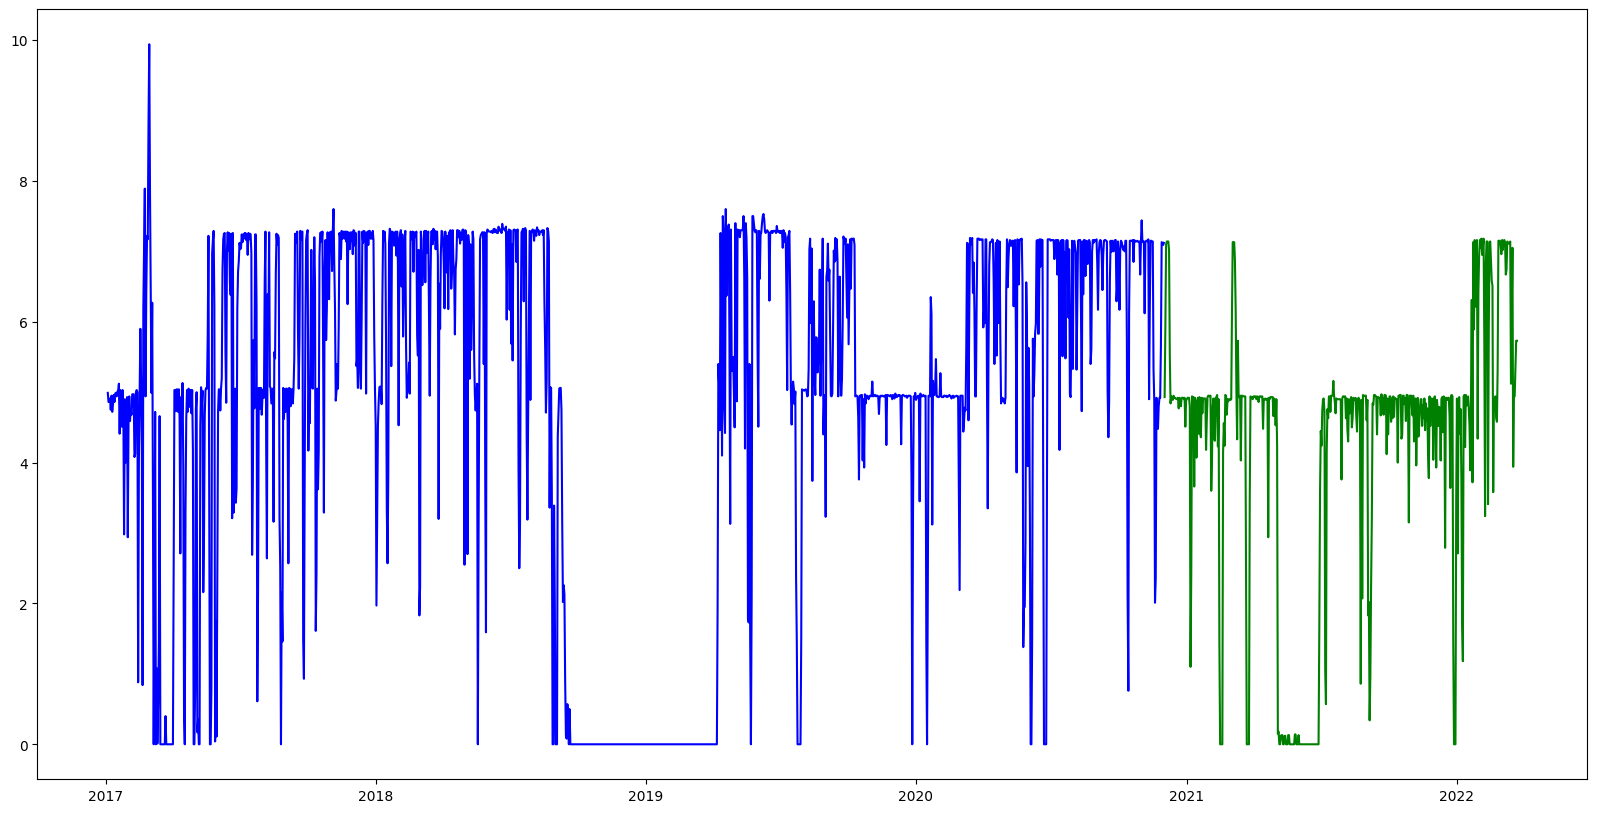

In [38]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot Training Data
train_plot, = plt.plot(data['DATE'][:len(y_train_treated_actual)], y_train_treated_actual, label='Training Data', color='blue')

# Plot Test Data
test_plot, = plt.plot(data['DATE'][len(y_train_treated_actual):len(y_train_treated_actual) + len(y_test_treated_actual)], y_test_treated_actual, label='Test Data', color='green')

# Overlay Predicted Data using best_gb_treated model
predicted_plot, = plt.plot(data['DATE'][len(y_train_treated_actual):len(y_train_treated_actual) + len(y_test_treated_actual)], y_pred_train_treated_gb, label='Predictions', color='orange', linestyle='--')

# Add titles, labels, and legend with increased font sizes
plt.title('Treated Water: Training vs Test vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Treated Water (MG)', fontsize=16)
plt.legend(handles=[train_plot, test_plot, predicted_plot], fontsize=14)
plt.grid(True)

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot Training Data
train_plot, = plt.plot(data['DATE'][:len(y_train_energy_actual)], y_train_energy_actual, label='Training Data', color='blue')

# Plot Test Data
test_plot, = plt.plot(data['DATE'][len(y_train_energy_actual):len(y_train_energy_actual) + len(y_test_energy_actual)], y_test_energy_actual, label='Test Data', color='green')

# Overlay Predicted Data using best_rf_energy model
predicted_plot, = plt.plot(data['DATE'][len(y_train_energy_actual):len(y_train_energy_actual) + len(y_test_energy_actual)], y_pred_train_energy_rf, label='Predictions', color='orange', linestyle='--')

# Add titles, labels, and legend with increased font sizes
plt.title('Energy Consumption: Training vs Test vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily KWH', fontsize=16)
plt.legend(handles=[train_plot, test_plot, predicted_plot], fontsize=14)
plt.grid(True)

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


# 5 Years Prediction From the Best Model

In [ ]:
import random

# Initialize lists to store predictions
treated_predictions = []
energy_predictions = []

In [ ]:
# Number of loops needed to reach 1825 predictions
n_loops = 1825 // len(X_train_actual)  # Integer division to get full loops
remaining_rows = 1825 % len(X_train_actual)  # Remaining rows after full loops

In [ ]:
X_future = X_train_actual.iloc[:1825].reset_index(drop=True)

In [ ]:
# Add the remaining rows
if remaining_rows > 0:
    X_future = pd.concat([X_future, X_train_actual.iloc[:remaining_rows]], ignore_index=True)

In [ ]:
# Make the predictions using the GB models
pred_treated = best_gb_treated.predict(X_future)
pred_energy = best_rf_energy.predict(X_future)

# Append the predictions to the lists
treated_predictions.extend(pred_treated)
energy_predictions.extend(pred_energy)


In [ ]:
# Convert predictions to DataFrame
pred_df = pd.DataFrame({
    'Water Flow': treated_predictions,
    'Daily KWH': energy_predictions
})

In [ ]:
# Generate a date column
last_date = pd.to_datetime(data['DATE'].iloc[-1])
future_dates = pd.date_range(start=last_date, periods=len(treated_predictions) + 1, freq='D')[1:]

In [ ]:
# Add the 'Date' column and rearrange it to be the first column
pred_df['DATE'] = future_dates
pred_df = pred_df[['DATE', 'Water Flow', 'Daily KWH']]

In [ ]:
# Export to CSV
pred_df.to_csv('Future_Predictions.csv', index=False)

print("Predictions exported to Future_Predictions.csv")

In [ ]:
# Plot Actual Treated Water

plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
plt.plot(data['DATE'], data['Water Flows'], label='Treated Water', color='blue')
plt.plot(pred_df['DATE'], pred_df['Water Flow'], label='Predicted Treated Water', color='orange')
plt.title('Treated Water: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Treated Water')
plt.legend()

plt.savefig("Predicted Treated water for San Antonio Site.png", dpi=300, bbox_inches='tight')

In [ ]:
# Set the figure size
plt.figure(figsize=(20, 20))



# Plot Actual Energy Consumption
plt.subplot(2, 1, 2)
plt.plot(data['DATE'], data['Daily KWH'], label='Actual Energy Consumption', color='green')
plt.plot(pred_df['DATE'], pred_df['Daily KWH'], label='Predicted Energy Consumption', color='red')
plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Daily Energy Consumption')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


plt.savefig("Predicted Energy Consumption for San Antonio Site.png", dpi=300, bbox_inches='tight')

# Saving the Best Model for both Treated Water and Energy Consumption

In [ ]:
import pickle

# Saving the Gradient Boosting model for treated water
with open('best_gb_treated.pkl', 'wb') as f:
    pickle.dump(best_gb_treated, f)

# Saving the Gradient Boosting model for energy consumption
with open('best_rf_energy.pkl', 'wb') as f:
    pickle.dump(best_rf_energy, f)


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# Loading the Gradient Boosting model for treated water
with open('best_gb_treated.pkl', 'rb') as f:
    loaded_gb_treated = pickle.load(f)

# Loading the Gradient Boosting model for energy consumption
with open('best_gb_energy.pkl', 'rb') as f:
    loaded_gb_energy = pickle.load(f)